In [4]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
from skimage.util import crop
import datetime
import os
import matplotlib.pyplot as plt

In [5]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In [6]:
train_doc = np.random.permutation(open('F:\\UPGRAD\\5. Deep Learning\\Module 6 - Gesture recognition assignment\\Project_data\\Project_data\\train.csv').readlines())
val_doc = np.random.permutation(open('F:\\UPGRAD\\5. Deep Learning\\Module 6 - Gesture recognition assignment\\Project_data\\Project_data\\val.csv').readlines())

In [7]:
batch_size = 25

In [8]:
x = 30 #number of images selected in img_idx
y = 120 #size of image 
z = 120 #size of image 

### Generator Function

In [9]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    img_idx = [x for x in range(0,x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    img_new = crop(image, ((45, 45), (0, 0), (0,0)), copy=False)
                    img_new = resize(img_new,(y,z))
                    
                    img_new = img_new/255 # normalising 
                    
                    batch_data[folder,idx,:,:,0] = (img_new[:,:,0])#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (img_new[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (img_new[:,:,2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            # new batch size is the rest of the folders present after dividing the batch
            for batch in range(num_batches): # we iterate over the number of batches
                batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                        #crop the images and resize them. Note that the images are of 2 different shape 
                        #and the conv3D will throw error if the inputs in a batch have different shapes
                        img_new = crop(image, ((45, 45), (0, 0), (0,0)), copy=False)
                        img_new = resize(image,(y,z))
                    
                        img_new = img_new/255 # normalising 
                    
                        batch_data[folder,idx,:,:,0] = (img_new[:,:,0])#normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = (img_new[:,:,1])#normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = (img_new[:,:,2])#normalise and feed in the image
                    
                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [10]:
train_path = 'F:\\UPGRAD\\5. Deep Learning\\Module 6 - Gesture recognition assignment\\Project_data\\Project_data\\train'
val_path = 'F:\\UPGRAD\\5. Deep Learning\\Module 6 - Gesture recognition assignment\\Project_data\\Project_data\\val'

In [11]:
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 12 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 12


## Model Building

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

#write your model here
num_classes = 5

### 1. 3DConv Model

#### Initialising Model

In [10]:
model = Sequential()

model.add(Conv3D(16, #number of filters 
                 kernel_size=(3,3,3), 
                 input_shape=(x, y, z, 3),
                 padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, #Number of filters 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, #Number of filters 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(128, #Number of filters 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())
model.add(Dense(1000, activation='relu'))

#model.add(Flatten())
model.add(Dense(500, activation='relu'))

#softmax layer
model.add(Dense(num_classes, activation='softmax'))

In [11]:
#optimiser = optimizers.SGD(lr=0.001, momentum=0.9)
optimiser = optimizers.Adam(lr=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

Adam optimiser gives better results as compared to SGD optimiser.

In [12]:
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 30, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_1 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 30, 30, 32)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 7, 30, 30, 64)     5

In [13]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [14]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
#filepath = self.filepath.format(epoch=epoch + 1, **logs)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = num_epochs)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

In [15]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

#### Fitting the Model

In [16]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  F:\UPGRAD\5. Deep Learning\Module 6 - Gesture recognition assignment\Project_data\Project_data\train ; batch size = 25
Epoch 1/12
27/27 [==============================] - 699s 26s/step - loss: 1.6481 - categorical_accuracy: 0.1885 - val_loss: 1.5285 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2021-06-2804_45_45.558140\model-00001-1.62066-0.20513-1.52854-0.23000.h5
Epoch 2/12
27/27 [==============================] - 377s 14s/step - loss: 1.4519 - categorical_accuracy: 0.2767 - val_loss: 1.3912 - val_categorical_accuracy: 0.4000

Epoch 00002: saving model to model_init_2021-06-2804_45_45.558140\model-00002-1.38657-0.32764-1.39116-0.40000.h5
Epoch 3/12
27/27 [==============================] - 375s 14s/step - loss: 1.2756 - categorical_accuracy: 0.4141 - val_loss: 1.0407 - val_categorical_accuracy: 0.5400

Epoch 00003: saving model to model_init_2021-06-2804_45_45.558140\model-00003-1.20603-0.48148-1.04074-0.54000.h5
Epoch 4/12
27/27 [========

#### Plotting Train and Validation Accuracy

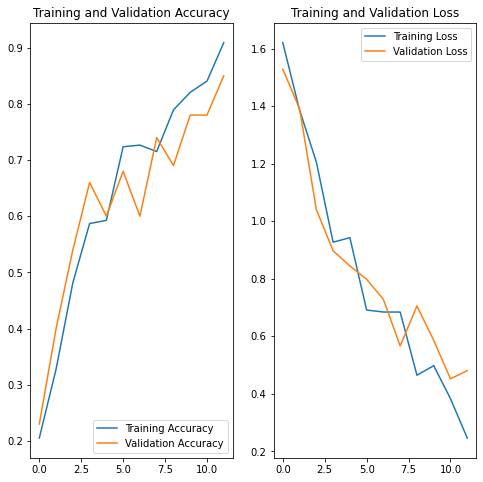

In [17]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()